In [1]:
import sys
sys.path.append('../')

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from scipy.optimize import linear_sum_assignment

from utils import show_test_images

In [2]:
image_dir = f'../images'
merfish_dir = f'{image_dir}/merfish'

# Load images and masks

In [3]:
# Load images in train and test dirs
merfish_image_names = glob(f'{merfish_dir}/test/images/*.tif')
merfish_image_names.extend(glob(f'{merfish_dir}/train/images/*.tif'))
merfish_image_names.sort(key=lambda name: name[-6:])
merfish_images = [cv.imread(img) for img in merfish_image_names]

In [4]:
# Load masks in train and test dirs
merfish_mask_names = glob(f'{merfish_dir}/test/masks/*.tif')
merfish_mask_names.extend(glob(f'{merfish_dir}/train/masks/manual/*.tif'))
merfish_mask_names.sort(key=lambda name: name[-6:])
merfish_masks = [cv.imread(img, cv.IMREAD_UNCHANGED) for img in merfish_mask_names]

# OpenCV Watershed
Try using watershed from OpenCV with a demo image. OpenCV's watershed uses marker-based watershed - adapted from: https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html

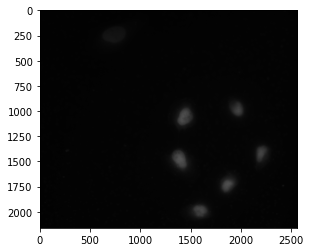

In [5]:
demo_img = merfish_images[7]
plt.imshow(demo_img);

# Convert to 8bit grayscale
demo_img_gray = cv.cvtColor(demo_img, cv.COLOR_BGR2GRAY)

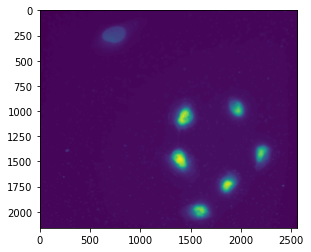

In [6]:
# Median filtering to remove noise
demo_img_gray_filter = cv.medianBlur(demo_img_gray, 7)
plt.imshow(demo_img_gray_filter);

9.0


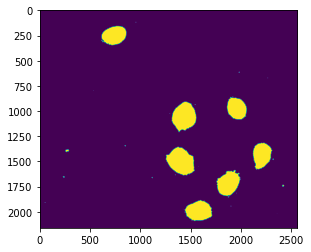

In [7]:
# Threshold foreground and background using Triangle thresholding
thresh_val, thresh_img = cv.threshold(demo_img_gray_filter, 0, 255, cv.THRESH_TRIANGLE)
print(thresh_val)
plt.imshow(thresh_img);

In [8]:
# Remove noise
kernel = np.ones((3,3), np.uint8)
opening = cv.morphologyEx(thresh_img, cv.MORPH_OPEN, kernel, iterations = 2)

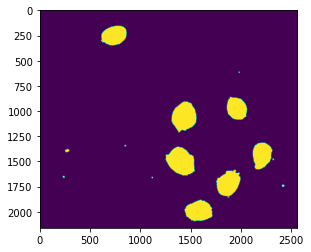

In [9]:
# Find area that is sure to be background using dilate
background = cv.dilate(opening, kernel, iterations=3)
plt.imshow(background);

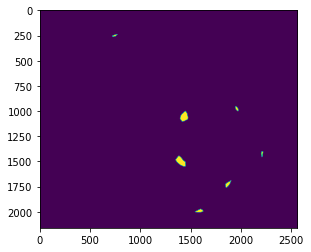

In [10]:
# Find area that is sure to be the foreground using distance transform and thresholding
dist_transform = cv.distanceTransform(opening,cv.DIST_L2, 5)
_, foreground = cv.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
plt.imshow(foreground);

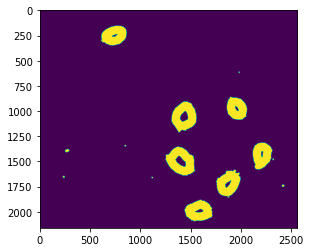

In [11]:
# Find area that is left, which is unknown to be foreground or background
foreground = np.uint8(foreground)
unknown = cv.subtract(background, foreground)
plt.imshow(unknown);

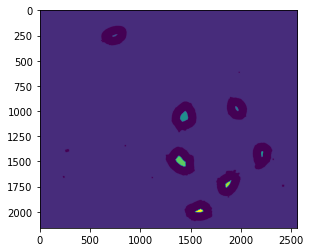

In [12]:
# Marker labelling
_, markers = cv.connectedComponents(foreground)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

plt.imshow(markers);

The unknown regions are marked in the deep purple, and the background is labelled with the lighter purple. The rest are labelled per each connected component.

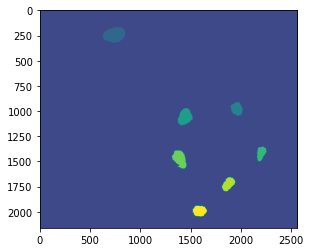

In [13]:
# Watershed
markers = cv.watershed(demo_img, markers)
plt.imshow(markers);

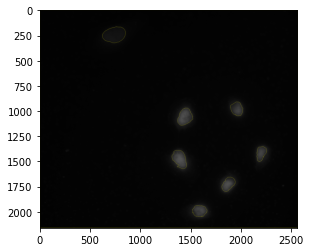

In [14]:
# Show boundaries on original image
demo_img[markers == -1] = [255,255,0]
plt.imshow(demo_img);

The `watershed` function returns an image in which pixels are labelled with the original seed values or -1 for boundary regions.

For ease of calculation of IoU, set all the -1 regions to 1 (which represents background), then subtract 1 from all values to get the original labelling.

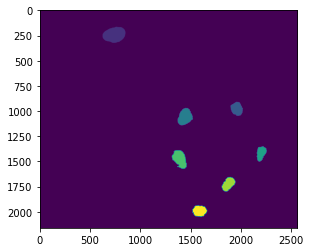

In [15]:
markers[markers == -1] = 1
markers -= 1
plt.imshow(markers);

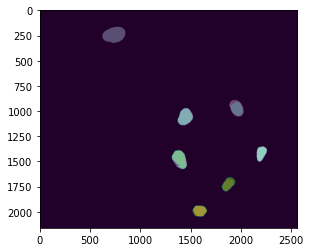

In [16]:
# Show the mask image with the result overlayed
plt.imshow(merfish_masks[7], cmap=plt.cm.gray);
plt.imshow(markers, alpha=0.5);

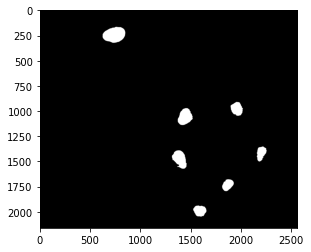

In [17]:
# Get intersection between result and mask
intersection = np.logical_and(markers, merfish_masks[7])
plt.imshow(intersection, cmap=plt.cm.gray);

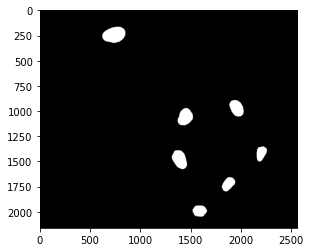

In [18]:
# Get union between result and mask
union = np.logical_or(markers, merfish_masks[7])
plt.imshow(union, cmap=plt.cm.gray);

In [19]:
# IoU for entire image
iou = np.sum(intersection) / np.sum(union)
print(iou)

0.8674261826473455


To get the true positive values, use the same method used in StarDist: if a predicted object has a corresponding ground truth object with a IoU value greater than a threshold, consider it a true positive.

Adapted from StarDist: https://github.com/mpicbg-csbd/stardist/blob/0c737544a05ae3f6b60667516d2d25e0cebef265/stardist/matching.py


In [29]:
def get_confusion_matrix_vals(true, pred, thresh):
    """
    TODO: write doc, assumes true and pred have same labels, returns tp, fp, fn
    """
    x = true.copy().ravel()
    y = pred.copy().ravel()

    # Get overlapping counts between x and y
    overlap = np.zeros((1 + x.max(), 1 + y.max()), dtype=np.uint)
    for i in range(len(x)):
        overlap[x[i],y[i]] += 1

    # Get matrix of IoU values for each pair of labels
    if np.sum(overlap) != 0:
        n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
        n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
        scores = overlap / (n_pixels_pred + n_pixels_true - overlap)
    else:
        scores = overlap
    
    scores = scores[1:,1:]
    n_true, n_pred = scores.shape
    n_matched = min(n_true, n_pred)
    
    # Get best pair matches
    if n_matched > 0 and np.any(scores >= thresh):
        costs = -(scores >= thresh).astype(float) - scores / (2 * n_matched)
        true_ind, pred_ind = linear_sum_assignment(costs)
        print(f'IoU scores: {scores[true_ind, pred_ind]}')
        match_ok = scores[true_ind, pred_ind] >= thresh
        tp = np.count_nonzero(match_ok)
    else:
        tp = 0
    
    fp = n_pred - tp
    fn = n_true - tp

    return tp, fp, fn

In [30]:
get_confusion_matrix_vals(merfish_masks[7], markers, 0.5)

IoU scores: [0.76130734 0.87472071 0.95920617 0.71088336 0.87635756 0.92034333
 0.88088889]


(7, 0, 0)